# Experiments

## Tasks
 - Find correlation between fields
 - Find correlation of fields with certain properties like:
        - Price
        - Rating
        - Rating count
- Check if we can build a regression / classification model for rating / rating count
- Check if we can build a regression model for price
- Cluster apps to see related apps;
- Check what fields can be used to perform KNN lookup to find similar apps

In [77]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("whitegrid")
sns.set_palette("Set1", 8, .75)

figsize = (10, 7)

In [2]:
df = pd.read_csv("../dataset/processed.data.csv", encoding='utf-8')

In [3]:
# let's list out all the columns
df.columns

Index(['bundleId', 'trackName', 'IsUniversal', 'advisories', 'fileSizeInMB',
       'contentAdvisoryRating', 'currentVersionReleaseDate', 'version',
       'subversion', 'artist', 'genres', 'price', 'description',
       'isVppDeviceBasedLicensingEnabled', 'primaryGenreName', 'releaseDate',
       'ageInDays', 'minimumOsVersion', 'averageUserRating', 'avgUserRatingCV',
       'userRatingCount', 'userRatingCountCV', 'hasUrl', 'sellerUrl',
       'sellerUrlDomain', 'releaseNotes'],
      dtype='object')

In [4]:
totalApps = df.shape[0]
totalFreeApps = df[df.price == 0].shape[0]

In [5]:
print ("Total Apps", totalApps)
print ("Total Free Apps: %d (%0.2f %%)" % (totalFreeApps, (totalFreeApps / totalApps * 100)))

Total Apps 325426
Total Free Apps: 291054 (89.44 %)


### Summary
 - Some apps are not available in the DB

# Some regression analysis

In [6]:
df1 = pd.DataFrame()
df1['name'] = df.trackName

In [7]:
# df.IsUniversal
def getIsUniversalBinary(b):
    if b == True:
        return 1
    return 0

df1['isUniversal'] = df.IsUniversal.apply(lambda x: getIsUniversalBinary(x))
df1.head(10)

,name,isUniversal
0,AAA Mobile,1
1,AAA GUN CLUB lite,0
2,Vanguard Online - AAA Shooting Free Online Gam...,1
3,AAA Bullet Party - Online first person shooter...,1
4,iSheacher,0
5,AAA American Civil War Cannon Shooter : Defend...,1
6,Draw with Powertools FX Free,1
7,AAA+ Foundr - Entrepreneur Magazine for a Startup,1
8,AAA+ Swimsuits & Sports Magazine App For Men,1
9,AAA 1024 Puzzle - cool math board game,1


In [8]:
df1['fileSizeInMB'] = df.fileSizeInMB

In [9]:
## let's one hot encode advisories
AdvisoriesIndex = 1
AllAdvisories = {}

tmprows = []

for ads in df.advisories:
    ads = json.loads(ads)
    tmprow = []
    for ad in ads:
        if ad not in AllAdvisories:
            AllAdvisories[ad] = AdvisoriesIndex
            AdvisoriesIndex = AdvisoriesIndex + 1
        tmprow.append(AllAdvisories[ad])
    tmprows.append(tmprow)

In [10]:
def getAdvisoryVal(i, j):
    if i in j:
        return 1
    return 0

df1['tmp'] = tmprows

for i in range(1, AdvisoriesIndex):
    key = 'Advisory.' +str(i)
    tmp = []
    
    df1[key] = df1['tmp'].apply(lambda x: getAdvisoryVal(i, x))

df1 = df1.drop(['tmp'], axis=1)
df1.head(10)

,name,isUniversal,fileSizeInMB,Advisory.1,Advisory.2,Advisory.3,Advisory.4,Advisory.5,Advisory.6,Advisory.7,...,Advisory.11,Advisory.12,Advisory.13,Advisory.14,Advisory.15,Advisory.16,Advisory.17,Advisory.18,Advisory.19,Advisory.20
0,AAA Mobile,1,153.721680,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AAA GUN CLUB lite,0,29.033732,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Vanguard Online - AAA Shooting Free Online Gam...,1,174.367188,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AAA Bullet Party - Online first person shooter...,1,1182.394531,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,iSheacher,0,1.434688,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
5,AAA American Civil War Cannon Shooter : Defend...,1,107.042969,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Draw with Powertools FX Free,1,56.867188,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,AAA+ Foundr - Entrepreneur Magazine for a Startup,1,32.477539,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,AAA+ Swimsuits & Sports Magazine App For Men,1,37.444336,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
9,AAA 1024 Puzzle - cool math board game,1,13.113281,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# let's replace Not Yet Rated to 4+ as 4+ is max value and NYR occurs like only 9 times < 0.01%
df.contentAdvisoryRating = df.contentAdvisoryRating.replace('Not yet rated', '4+')

In [12]:
for val in df.contentAdvisoryRating.value_counts().index:
    key = 'AR.' +val
    df1[key] = 0
    df1.loc[df.contentAdvisoryRating == val, key] = 1

df1.head(1)

,name,isUniversal,fileSizeInMB,Advisory.1,Advisory.2,Advisory.3,Advisory.4,Advisory.5,Advisory.6,Advisory.7,...,Advisory.15,Advisory.16,Advisory.17,Advisory.18,Advisory.19,Advisory.20,AR.4+,AR.17+,AR.12+,AR.9+
0,AAA Mobile,1,153.72168,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [13]:
for val in df.primaryGenreName.value_counts().index:
    key = 'PrimaryGenre.' +val
    df1[key] = 0
    df1.loc[df.primaryGenreName == val, key] = 1

df1.head(1)

,name,isUniversal,fileSizeInMB,Advisory.1,Advisory.2,Advisory.3,Advisory.4,Advisory.5,Advisory.6,Advisory.7,...,PrimaryGenre.Reference,PrimaryGenre.Food & Drink,PrimaryGenre.Social Networking,PrimaryGenre.News,PrimaryGenre.Shopping,PrimaryGenre.Book,PrimaryGenre.Navigation,PrimaryGenre.Stickers,PrimaryGenre.Weather,PrimaryGenre.Magazines & Newspapers
0,AAA Mobile,1,153.72168,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df1['price'] = df.price

In [69]:
df2 = df1[df1.price > 0]

In [70]:
df2.price.describe()

count    34372.000000
mean         4.892886
std         17.395455
min          0.990000
25%          0.990000
50%          1.990000
75%          3.990000
max        999.990000
Name: price, dtype: float64

In [71]:
print ("No of apps with price > 10", df2[df2.price > 10].shape[0])

print ("Percentage of such apps: ", (df2[df2.price > 10].shape[0] / df2.shape[0] * 100))

No of apps with price > 10 2263
Percentage of such apps:  6.5838473175840795


Since the no of apps is very low, we wil remove them from regression;

In [72]:
df2 = df2[df2.price <= 10]

In [90]:
Y = df2.price.values
X = df2.drop(['price', 'name'], axis=1).values

Min: 0.990, Max: 9.990
[0.0 - 1.0) = 12186
[1.0 - 2.0) = 6865
[2.0 - 3.0) = 4934
[3.0 - 4.0) = 2048
[4.0 - 5.0) = 2777
[5.0 - 6.0) = 751
[6.0 - 7.0) = 588
[7.0 - 8.0) = 419
[8.0 - 9.0) = 277
[9.0 - 10.0) = 1264


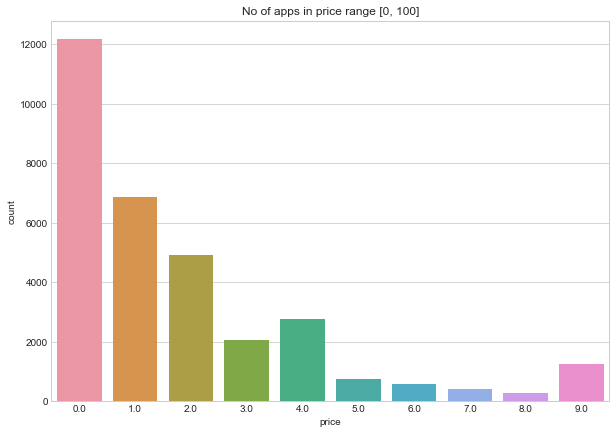

In [208]:
## plotting a distribution myself
import math
plt.figure(figsize=figsize)

bins = 10
divisor = (10 / bins)
freq = np.zeros((bins, 2))
YMax, YMin = Y.max(), Y.min()
print ("Min: %0.3f, Max: %0.3f" % (YMin, YMax))

for price in Y:
    freq[math.floor(price / divisor)][1] = freq[math.floor(price / divisor)][1] + 1

freq[:, 0] = [i * divisor for i in range(0, bins)]

hist = pd.DataFrame(freq, columns=['price', 'count'])
sns.barplot(x='price', y='count', data=hist)

for priceMin, count in freq:
    print ("[%0.1f - %0.1f) = %d" % (priceMin, priceMin + divisor, count))
        
plt.title("No of apps in price range [0, 100]")

In [79]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

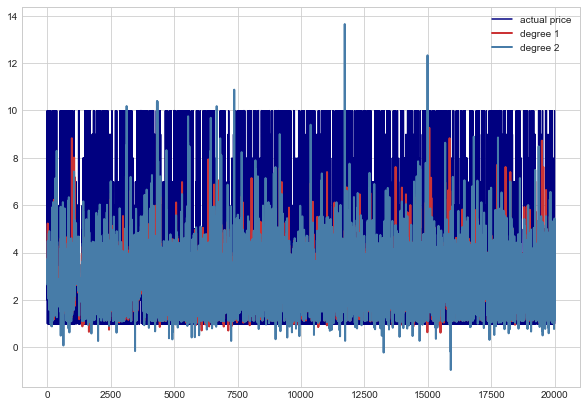

In [99]:
n_samples = 20000

# plotting the ground truth
plt.figure(figsize=figsize)
plt.plot(Y[:n_samples], color='navy', label="actual price")

# print (Y)

for count, degree in enumerate(range(1, 3)):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(X[:n_samples], Y[:n_samples])
    y_plot = model.predict(X[:n_samples])
    plt.plot(y_plot, linewidth=2, label="degree %d" % degree)

plt.legend()
plt.show()

In [140]:
Z = np.zeros((Y.shape[0]))
for i, y in enumerate(Y):
    if y > 1:
        Z[i] = 1

X_train, X_test, y_train, y_test = train_test_split(X, Z, test_size=0.2, random_state=42)

In [220]:
import sys

from sklearn.model_selection import train_test_split


from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

LINE = "------------------------------------------------------------------------------"

classifiers = {
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
#     "Logistic Regression": LogisticRegression(),
#     "SVM Linear Kernel": SVC(),
    "Random Forest": RandomForestClassifier(max_depth=20),
#     "Gradient Boosting": GradientBoostingClassifier(),
    "ExtraTreeClassifier": ExtraTreeClassifier(),
    "ExtraTreesClassifier": ExtraTreesClassifier(),    # note that this one is an ensemble
#     "KNeighborsClassifier": KNeighborsClassifier(),
#     "RidgeClassifier": RidgeClassifier(),
#     "RidgeClassifierCV": RidgeClassifier()
}

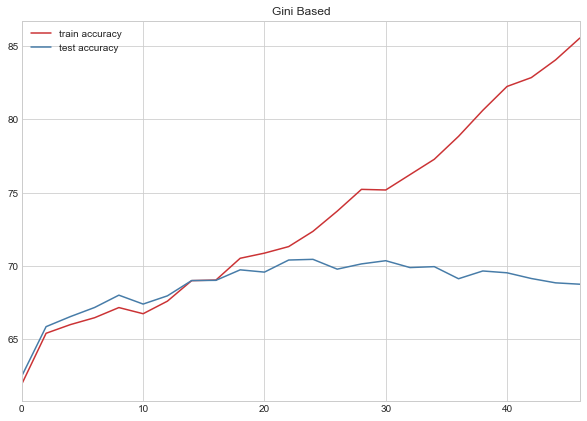

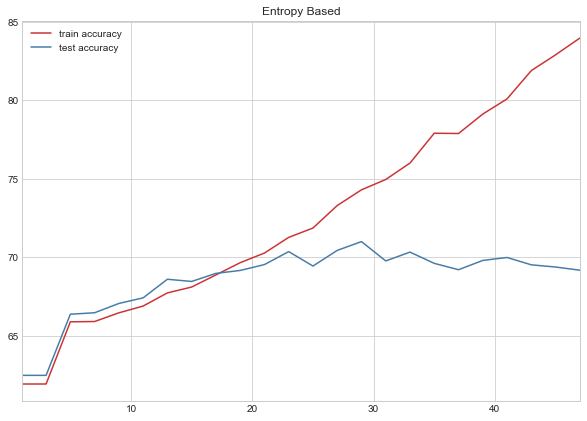

In [176]:
_df = pd.DataFrame(data, columns=['depth', 'criteria', 'train accuracy', 'test accuracy'])

_df[_df['criteria'] == 'gini'][['train accuracy', 'test accuracy']].plot(figsize=figsize, kind='line')
plt.title("Gini Based")

_df[_df['criteria'] != 'gini'][['train accuracy', 'test accuracy']].plot(figsize=figsize, kind='line')
plt.title("Entropy Based")

In [183]:
param_grid = {
    "max_depth": [10, 15, 20],
    "min_samples_split": [2, 3, 10],
#     "min_samples_leaf": [1, 3, 10],
#     "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
    "n_estimators": [20, 50, 100]
}

In [199]:
# Grid search
from sklearn.model_selection import GridSearchCV
from time import time

'''
# Best features so far;;

n_estimators=100,
bootstrap=True,
criterion='gini',
max_depth=15,
max_features=15,
min_samples_split=2
'''

params = {
    'max_features': [10, 15, 20, 25, 30],
    'min_samples_split': [2, 3, 5, 10],
    'bootstrap': [True, False]
}
clf = RandomForestClassifier(n_estimators=100,
                            criterion='gini',
                            max_depth=15)

# run grid search
grid_search = GridSearchCV(clf, param_grid=params, verbose=10, cv=2)
start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))


Fitting 2 folds for each of 40 candidates, totalling 80 fits
[CV] bootstrap=True, min_samples_split=2, max_features=10 ............
[CV]  bootstrap=True, min_samples_split=2, max_features=10, score=0.689427, total=   2.2s
[CV] bootstrap=True, min_samples_split=2, max_features=10 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV]  bootstrap=True, min_samples_split=2, max_features=10, score=0.694620, total=   2.2s
[CV] bootstrap=True, min_samples_split=3, max_features=10 ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s


[CV]  bootstrap=True, min_samples_split=3, max_features=10, score=0.691218, total=   1.6s
[CV] bootstrap=True, min_samples_split=3, max_features=10 ............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.0s remaining:    0.0s


[CV]  bootstrap=True, min_samples_split=3, max_features=10, score=0.696099, total=   1.5s
[CV] bootstrap=True, min_samples_split=5, max_features=10 ............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.8s remaining:    0.0s


[CV]  bootstrap=True, min_samples_split=5, max_features=10, score=0.693086, total=   1.5s
[CV] bootstrap=True, min_samples_split=5, max_features=10 ............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.7s remaining:    0.0s


[CV]  bootstrap=True, min_samples_split=5, max_features=10, score=0.693607, total=   1.5s
[CV] bootstrap=True, min_samples_split=10, max_features=10 ...........


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   12.5s remaining:    0.0s


[CV]  bootstrap=True, min_samples_split=10, max_features=10, score=0.691763, total=   1.5s
[CV] bootstrap=True, min_samples_split=10, max_features=10 ...........


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   14.3s remaining:    0.0s


[CV]  bootstrap=True, min_samples_split=10, max_features=10, score=0.693685, total=   1.8s
[CV] bootstrap=True, min_samples_split=2, max_features=15 ............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   16.5s remaining:    0.0s


[CV]  bootstrap=True, min_samples_split=2, max_features=15, score=0.691062, total=   2.4s
[CV] bootstrap=True, min_samples_split=2, max_features=15 ............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   19.3s remaining:    0.0s


[CV]  bootstrap=True, min_samples_split=2, max_features=15, score=0.694308, total=   2.3s
[CV] bootstrap=True, min_samples_split=3, max_features=15 ............
[CV]  bootstrap=True, min_samples_split=3, max_features=15, score=0.690050, total=   2.6s
[CV] bootstrap=True, min_samples_split=3, max_features=15 ............
[CV]  bootstrap=True, min_samples_split=3, max_features=15, score=0.697423, total=   2.2s
[CV] bootstrap=True, min_samples_split=5, max_features=15 ............
[CV]  bootstrap=True, min_samples_split=5, max_features=15, score=0.692152, total=   2.2s
[CV] bootstrap=True, min_samples_split=5, max_features=15 ............
[CV]  bootstrap=True, min_samples_split=5, max_features=15, score=0.693218, total=   2.3s
[CV] bootstrap=True, min_samples_split=10, max_features=15 ...........
[CV]  bootstrap=True, min_samples_split=10, max_features=15, score=0.692541, total=   2.2s
[CV] bootstrap=True, min_samples_split=10, max_features=15 ...........
[CV]  bootstrap=True, min_samples

[CV]  bootstrap=False, min_samples_split=5, max_features=20, score=0.686702, total=   4.0s
[CV] bootstrap=False, min_samples_split=5, max_features=20 ...........
[CV]  bootstrap=False, min_samples_split=5, max_features=20, score=0.692751, total=   4.3s
[CV] bootstrap=False, min_samples_split=10, max_features=20 ..........
[CV]  bootstrap=False, min_samples_split=10, max_features=20, score=0.688415, total=   4.2s
[CV] bootstrap=False, min_samples_split=10, max_features=20 ..........
[CV]  bootstrap=False, min_samples_split=10, max_features=20, score=0.692517, total=   4.1s
[CV] bootstrap=False, min_samples_split=2, max_features=25 ...........
[CV]  bootstrap=False, min_samples_split=2, max_features=25, score=0.682809, total=   4.5s
[CV] bootstrap=False, min_samples_split=2, max_features=25 ...........
[CV]  bootstrap=False, min_samples_split=2, max_features=25, score=0.689325, total=   4.6s
[CV] bootstrap=False, min_samples_split=3, max_features=25 ...........
[CV]  bootstrap=False, min

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  4.9min finished


GridSearchCV took 301.69 seconds for 40 candidate parameter settings.


In [201]:
grid_search.best_params_

{'bootstrap': True, 'max_features': 20, 'min_samples_split': 10}

In [219]:
#using these params
clf = RandomForestClassifier(n_estimators=100,
                             bootstrap=True,
                             criterion='gini',
                             max_depth=15,
                             max_features=20,
                             min_samples_split=10
                            )
clf.fit(X_train, y_train)

print (LINE)
print ("metrics on training data")
pred = clf.predict(X_train)
print ("Accuracy: ", accuracy_score(y_train, pred))
print(classification_report(y_train, pred))

print (LINE)

print ("metrics on validation data")
pred = clf.predict(X_test)
print ("Accuracy: ", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))

------------------------------------------------------------------------------
metrics on training data
Accuracy:  0.748471989722
             precision    recall  f1-score   support

        0.0       0.79      0.46      0.58      9777
        1.0       0.74      0.92      0.82     15910

avg / total       0.76      0.75      0.73     25687

------------------------------------------------------------------------------
metrics on validation data
Accuracy:  0.709592027406
             precision    recall  f1-score   support

        0.0       0.69      0.41      0.51      2409
        1.0       0.71      0.89      0.79      4013

avg / total       0.71      0.71      0.69      6422



### Summary
 - We can build a classifier which can tell if an app should be priced above or below a dollar. What a waste!
 - Rather build a free / paid classifier;

In [231]:
Y = df1.price.values
X = df1.drop(['price', 'name'], axis=1).values
Z = np.zeros(Y.shape[0])
for i, j in enumerate(Y):
    if j != 0:
        Z[i] = 1

In [235]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Z, test_size=0.3, random_state=42)
print (x_train.shape, y_train.shape)
print (x_val.shape, y_val.shape)

(227798, 50) (227798,)
(97628, 50) (97628,)


In [238]:
#using these params
clf = RandomForestClassifier(n_estimators=100,
                             bootstrap=True,
                             criterion='gini',
                             max_depth=15,
                             max_features=20,
                             min_samples_split=10
                            )
clf.fit(x_train, y_train)

print (LINE)
print ("metrics on training data")
pred = clf.predict(x_train)
print ("Accuracy: ", accuracy_score(y_train, pred))
print(classification_report(y_train, pred))

------------------------------------------------------------------------------
metrics on training data
Accuracy:  0.902799848989
             precision    recall  f1-score   support

        0.0       0.90      1.00      0.95    203801
        1.0       0.85      0.09      0.17     23997

avg / total       0.90      0.90      0.87    227798



In [241]:
print (LINE)

print ("metrics on validation data")
pred = clf.predict(x_val)
print ("Accuracy: ", accuracy_score(y_val, pred))
print(classification_report(y_val, pred))

------------------------------------------------------------------------------
metrics on validation data
Accuracy:  0.899434588438
             precision    recall  f1-score   support

        0.0       0.90      1.00      0.95     87253
        1.0       0.75      0.08      0.15     10375

avg / total       0.88      0.90      0.86     97628



In [242]:
## let's dump this model
clf = RandomForestClassifier(n_estimators=100,
                             bootstrap=True,
                             criterion='gini',
                             max_depth=15,
                             max_features=20,
                             min_samples_split=10
                            )

clf.fit(X, Z)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=20, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [243]:
import pickle
with open("../models/classifier/free-paid.randomforest.01.pkl", "wb") as ofp:
    pickle.dump(clf, ofp)